<a href="https://colab.research.google.com/github/amanmaurya7/MIS-Captstone/blob/main/MIS_Captstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Upload Your Dataset**

---


First, you need to upload the customer_complaints.csv file you saved earlier to your Colab environment.

Run this cell. It will show a "Choose Files" button. Click it and select the CSV file from your computer.

In [ ]:
# Cell 1: File Upload
from google.colab import files

# This will prompt you to upload the CSV file.
uploaded = files.upload()

print("File uploaded successfully!")

Saving customer_complaints.csv to customer_complaints.csv
File uploaded successfully!


**Phase 1 & 2: Load, Clean, and Preprocess Data**

---


This phase involves loading the data and cleaning the text to make it ready for analysis. We'll remove noise (like punctuation and links), tokenize the text, remove common "stopwords," and lemmatize words to their root form.

In [ ]:
# Cell 2: Load and Preprocess
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK data (only needs to be done once)
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# --- 1. Load Data ---
# The filename should match the one you uploaded
df = pd.read_csv('customer_complaints.csv')

# --- 2. Text Cleaning and Preprocessing ---
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove mentions, URLs, and non-alphanumeric characters
    text = re.sub(r'@[A-Za-z0-9_]+|https?:\S+|[^a-zA-Z\s]', '', text)
    # Tokenize
    tokens = text.split()
    # Lemmatize and remove stopwords
    cleaned_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return " ".join(cleaned_tokens)

# Apply the preprocessing function to the complaint text
df['CleanedText'] = df['ComplaintText'].apply(preprocess_text)

# Display the first few rows with the new cleaned text column
print("Data after cleaning and preprocessing:")
print(df[['ComplaintText', 'CleanedText', 'Sentiment']].head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Data after cleaning and preprocessing:
                                       ComplaintText  \
0  My package is over a week late and the trackin...   
1  The build quality of the new X-1 speaker is te...   
2  I was on hold with customer service for 50 min...   
3  Why was I charged twice for my subscription th...   
4  Just received my order and I'm thrilled! The p...   

                                         CleanedText Sentiment  
0  package week late tracking hasnt updated day u...  Negative  
1  build quality new x speaker terrible feel chea...  Negative  
2  hold customer service minute disconnected furious  Negative  
3  charged twice subscription month need fixed im...  Negative  
4  received order im thrilled product work even b...  Positive  


**Phase 3: Sentiment Analysis (Two Methods)**

---


Here, we'll perform the core sentiment analysis. We will use two popular methods:

Method A (Simple): VADER, a lexicon-based tool that is fast and great for social media text.

Method B (Advanced): A Machine Learning model (Logistic Regression with TF-IDF) that you train on your data.



**Method A: VADER Lexicon-Based Analysis**

In [ ]:
# Cell 3: VADER Sentiment Analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download VADER lexicon (only needs to be done once)
nltk.download('vader_lexicon')

# Initialize the VADER sentiment intensity analyzer
sia = SentimentIntensityAnalyzer()

# Function to get VADER sentiment
def get_vader_sentiment(text):
    score = sia.polarity_scores(text)['compound']
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the function to get VADER sentiment predictions
df['VADER_Sentiment'] = df['CleanedText'].apply(get_vader_sentiment)

print("Comparison of Original Sentiment vs. VADER Prediction:")
print(df[['Sentiment', 'VADER_Sentiment']].head(10))

# See how well VADER did compared to your original labels
from sklearn.metrics import accuracy_score, classification_report
print("\nVADER Performance:")
print(f"Accuracy: {accuracy_score(df['Sentiment'], df['VADER_Sentiment']):.2f}")
print(classification_report(df['Sentiment'], df['VADER_Sentiment']))

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Comparison of Original Sentiment vs. VADER Prediction:
  Sentiment VADER_Sentiment
0  Negative        Positive
1  Negative        Negative
2  Negative        Negative
3  Negative        Negative
4  Positive        Positive
5  Positive        Positive
6  Negative         Neutral
7  Negative        Negative
8  Negative        Negative
9   Neutral         Neutral

VADER Performance:
Accuracy: 0.52
              precision    recall  f1-score   support

    Negative       0.97      0.43      0.60       378
     Neutral       0.17      0.60      0.26        50
    Positive       0.44      0.92      0.59        72

    accuracy                           0.52       500
   macro avg       0.53      0.65      0.48       500
weighted avg       0.81      0.52      0.56       500



**Method B: Machine Learning Model (TF-IDF + Logistic Regression)**

---


This is a more robust approach where you train a model to understand the sentiment patterns specific to your dataset.

In [ ]:
# Cell 4: Machine Learning Model
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# --- 1. Define Features (X) and Target (y) ---
X = df['CleanedText']
y = df['Sentiment']

# --- 2. Split Data into Training and Testing sets ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- 3. Vectorize Text Data using TF-IDF ---
# TF-IDF converts text into meaningful numerical vectors
tfidf_vectorizer = TfidfVectorizer(max_features=2000) # Use top 2000 features
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# --- 4. Train a Logistic Regression Model ---
model = LogisticRegression(solver='liblinear')
model.fit(X_train_tfidf, y_train)

# --- 5. Evaluate the Model ---
y_pred = model.predict(X_test_tfidf)

print("Machine Learning Model Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Machine Learning Model Performance:
Accuracy: 0.76

Classification Report:
              precision    recall  f1-score   support

    Negative       0.76      1.00      0.86        76
     Neutral       0.00      0.00      0.00        10
    Positive       0.00      0.00      0.00        14

    accuracy                           0.76       100
   macro avg       0.25      0.33      0.29       100
weighted avg       0.58      0.76      0.66       100



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**Phase 4: Visualization and Dashboard Insights**

---


Now, we'll create the visualizations for your dashboard to present the findings in an easy-to-understand format.

/tmp/ipython-input-166600361.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment', data=df, order=['Positive', 'Neutral', 'Negative'], palette='viridis')


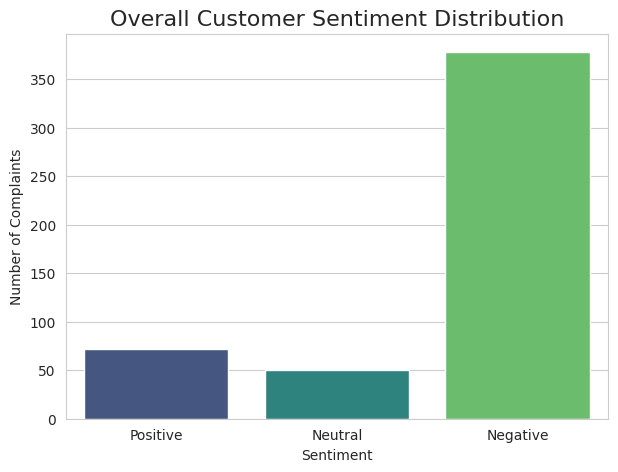

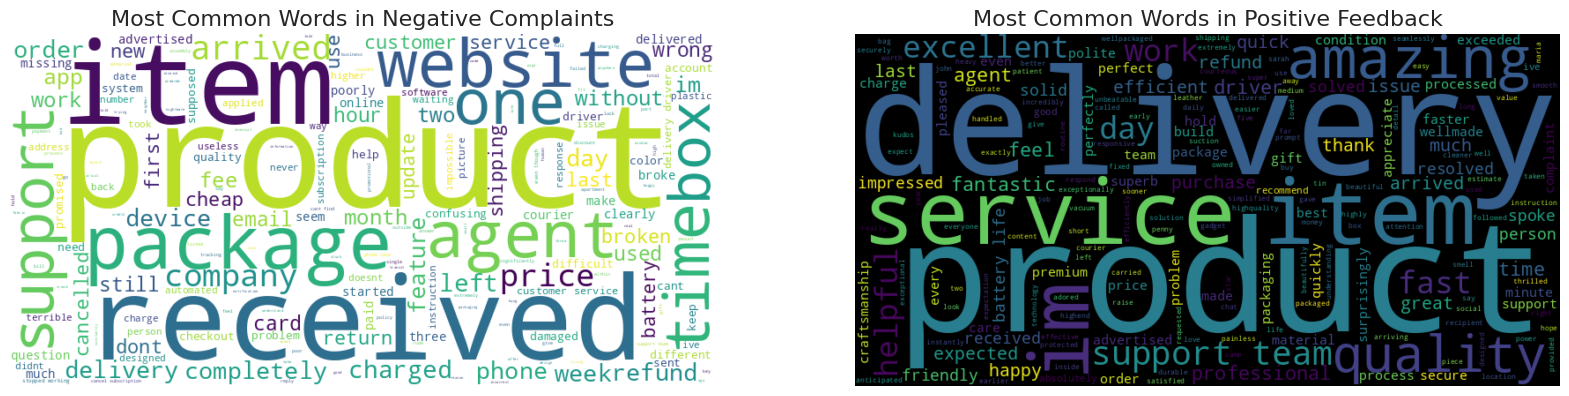

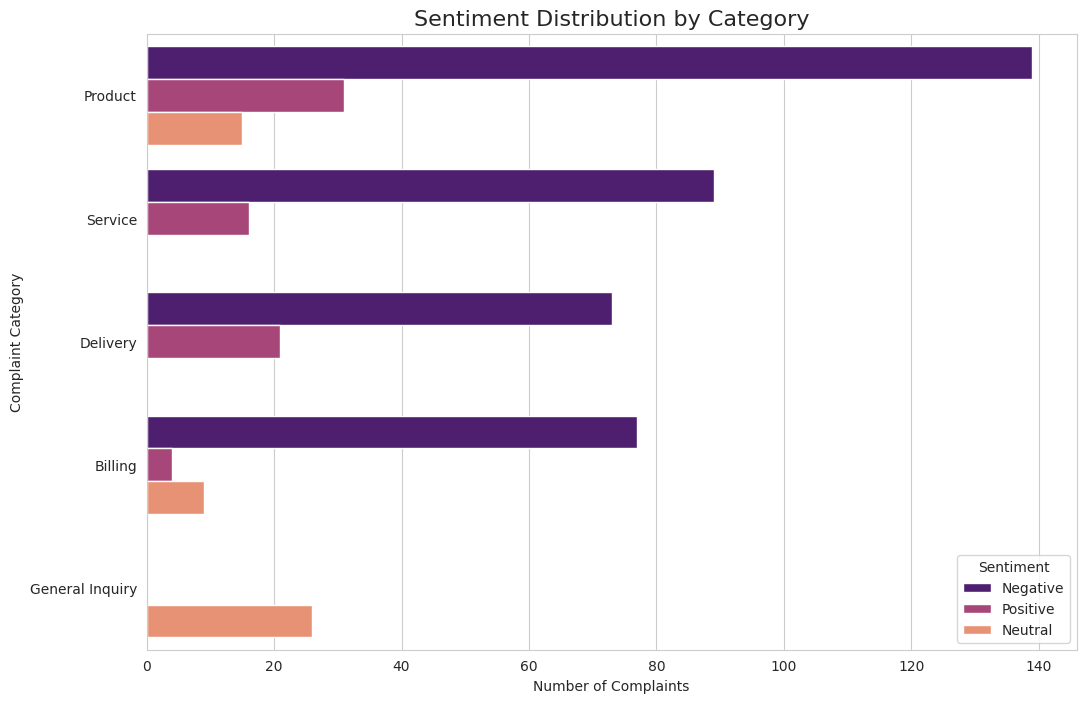

In [ ]:
# Cell 5: Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Set plot style
sns.set_style('whitegrid')

# --- 1. Overall Sentiment Distribution ---
plt.figure(figsize=(7, 5))
sns.countplot(x='Sentiment', data=df, order=['Positive', 'Neutral', 'Negative'], palette='viridis')
plt.title('Overall Customer Sentiment Distribution', fontsize=16)
plt.xlabel('Sentiment')
plt.ylabel('Number of Complaints')
plt.show()


# --- 2. Word Clouds for Positive vs. Negative Sentiment ---
negative_text = " ".join(df[df['Sentiment'] == 'Negative']['CleanedText'])
positive_text = " ".join(df[df['Sentiment'] == 'Positive']['CleanedText'])

wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(negative_text)
wordcloud_pos = WordCloud(width=800, height=400, background_color='black').generate(positive_text)

# Plotting the word clouds
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(wordcloud_neg, interpolation='bilinear')
ax1.set_title('Most Common Words in Negative Complaints', fontsize=16)
ax1.axis('off')

ax2.imshow(wordcloud_pos, interpolation='bilinear')
ax2.set_title('Most Common Words in Positive Feedback', fontsize=16)
ax2.axis('off')
plt.show()


# --- 3. Sentiment by Category ---
plt.figure(figsize=(12, 8))
sns.countplot(y='Category', hue='Sentiment', data=df, palette='magma',
              order=df['Category'].value_counts().index)
plt.title('Sentiment Distribution by Category', fontsize=16)
plt.xlabel('Number of Complaints')
plt.ylabel('Complaint Category')
plt.legend(title='Sentiment')
plt.show()

**Phase 5: Actionable Insights - Identifying Critical Complaints**

---


A key goal is to enable a fast response. This code identifies the top 10 most severe negative complaints so they can be addressed immediately. We'll use the VADER scores for this, as they provide a continuous measure of negativity.

In [ ]:
# Cell 6: Identify Most Critical Complaints
# First, let's calculate the compound score from VADER for sorting
df['VADER_Compound'] = df['CleanedText'].apply(lambda text: sia.polarity_scores(text)['compound'])

# Filter for only negative complaints
critical_complaints = df[df['Sentiment'] == 'Negative'].copy()

# Sort by the compound score (more negative is worse)
critical_complaints = critical_complaints.sort_values(by='VADER_Compound', ascending=True)

print("Top 10 Most Critical Negative Complaints to Address Immediately:")
# Display the top 10 most negative original complaints
for index, row in critical_complaints.head(10).iterrows():
    print(f"ID: {row['ComplaintID']} | Category: {row['Category']} | Score: {row['VADER_Compound']:.2f}")
    print(f"-> Complaint: {row['ComplaintText']}\n")

# Export report
df.to_csv('sentiment_results.csv', index=False)

Top 10 Most Critical Negative Complaints to Address Immediately:
ID: 195 | Category: Product | Score: -0.81
-> Complaint: A critical component failed and now the entire unit is useless.

ID: 451 | Category: Billing | Score: -0.77
-> Complaint: You charged my card after I cancelled my trial. I am reporting this as fraud.

ID: 434 | Category: Product | Score: -0.76
-> Complaint: The 'waterproof' phone case failed and my phone is now destroyed.

ID: 369 | Category: Product | Score: -0.74
-> Complaint: I was sent a used, dirty item instead of a new one. Disgusting.

ID: 92 | Category: Product | Score: -0.73
-> Complaint: The product broke during the first use. Extremely poor quality.

ID: 495 | Category: Product | Score: -0.73
-> Complaint: A key part failed, rendering the entire expensive product useless.

ID: 317 | Category: Product | Score: -0.72
-> Complaint: The item I received was damaged during shipping due to poor packaging.

ID: 274 | Category: Product | Score: -0.71
-> Complaint: